In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data
try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import *
    
from affinity_kimon import affinity
from skimage.color import rgb2gray
from skimage import data, segmentation, color
from skimage.future import graph
from skimage.segmentation import mark_boundaries

## Load image from skimage

In [2]:
img = data.hubble_deep_field()[0:500, 0:500]
[m,n] = img.shape[0:2]
n_pixels = m*n

## Construct an affinity matrix using our Cython implementation in affinity_kimon. You can replace this with your own adjacency matrix. If you want to use our implementation, please remember to recompile affinity_kimon.pyx under the notebooks folder.

In [3]:
data, row, col = affinity(n_pixels,m,n,2.0,8.0e+1,max(m,n),0.00001,img.astype(float))
A = sp.sparse.csc_matrix((data, (row, col)), shape=(n_pixels, n_pixels))

## Load the matrix in the LocalGraphClustering API

In [4]:
g = GraphLocal()
g.from_sparse_adjacency(A)

## Find all clusters and plot the NCP.

In [5]:
import warnings
warnings.filterwarnings('ignore')

ncp_instance = NCPData(g,store_output_clusters=True,do_largest_component=False)
ncp_instance.approxPageRank(ratio=1,nthreads=6,method = "l1reg-rand")

# ncp_plots = NCPPlots(ncp_instance,method_name = "l1reg-rand")
# #plot conductance vs size
# fig, ax, _ = ncp_plots.cond_by_size()
# plt.show()

approxPageRank:ncpapr_l1reg-rand:   47.4 neighborhoods
approxPageRank:ncpapr_l1reg-rand:   50.1 localmin rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:   52.5 localmin rho=1.0e-04
approxPageRank:ncpapr_l1reg-rand:  205.8 random_node rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  360.3 random_node rho=1.0e-04
approxPageRank:ncpapr_l1reg-rand:  513.5 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  668.1 random_neighborhood rho=1.0e-04


## Make an interactive NCP

In [6]:
p = NCPPlots(ncp_instance)
p.cond_by_size_itrv();

## Extract labels by thresholding based on conductance.

In [7]:
labels = np.zeros(n_pixels, dtype=np.int32)

sets = [st["output_cluster"] for st in ncp_instance.results]
sets_keep = []

ct = 0
for set_ in sets:
    cond = g.compute_conductance(set_)
    if cond < 5.0e-3:
        labels[set_] = ct
        sets_keep.append(set_)
        ct += 1

## Visualize the result

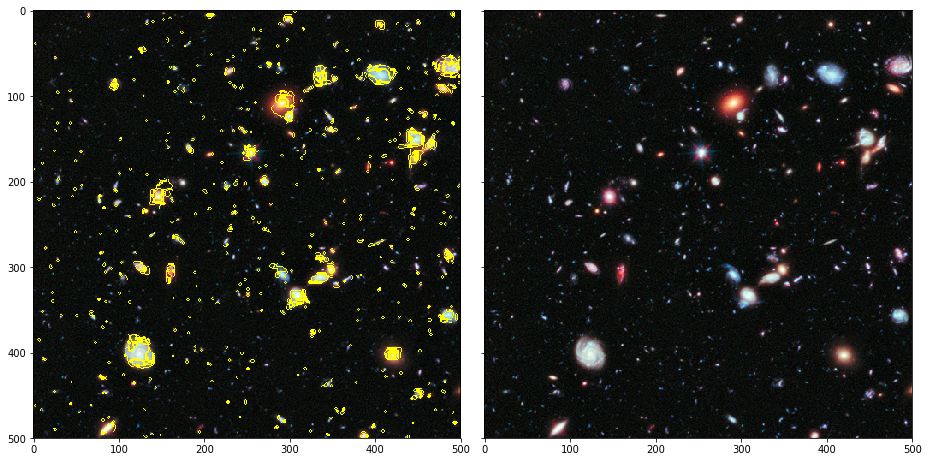

In [8]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(img)

#for a in ax:
    #a.axis('off')

plt.tight_layout()

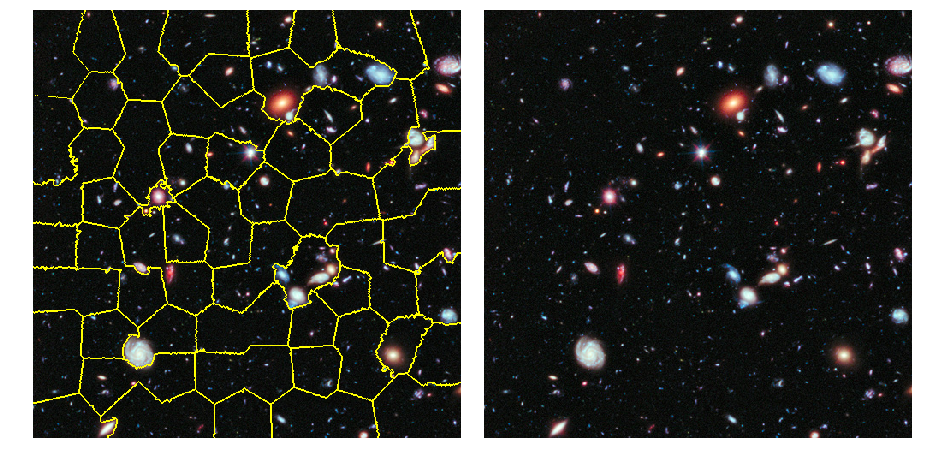

In [9]:
labels_slic = segmentation.slic(img, n_segments=100)
rag_ = graph.rag_mean_color(img, labels_slic, mode='similarity')
new_labels_slic = graph.cut_normalized(labels_slic, rag_, thresh=1, num_cuts=100)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, new_labels_slic))
ax[1].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Refined by MQI

In [10]:
sets_improve = []

for set_ in sets_keep:
    output_mqi = flow_clustering(g,set_,method="mqi_weighted")
    sets_improve.append(output_mqi[0])

## Compute labels

In [11]:
labels_improve = np.zeros(n_pixels, dtype=np.int32)

ct = 0
for set_ in sets_improve:
    labels_improve[set_] = ct
    ct += 1

## Visualize results

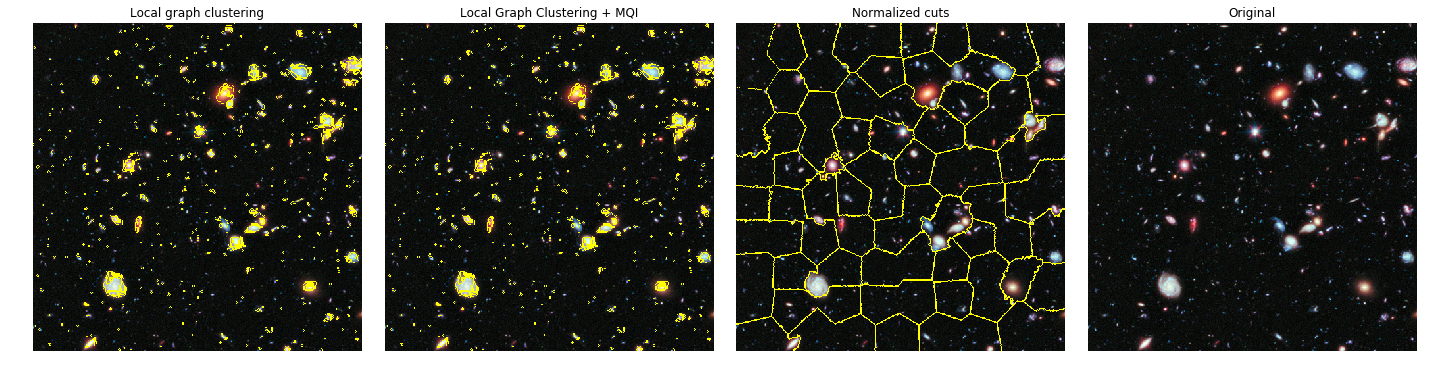

In [12]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(mark_boundaries(img, labels_improve.reshape((m,n))))
ax[2].imshow(mark_boundaries(img, new_labels_slic))
ax[3].imshow(img)

for a in ax:
    a.axis('off')
    
ax[0].set_title('Local graph clustering')
ax[1].set_title('Local Graph Clustering + MQI')
ax[2].set_title('Normalized cuts')
ax[3].set_title('Original')

plt.tight_layout()